# Biblioteca

In [ ]:
!pip install selenium webdriver-manager
!apt-get update
!apt-get install -y chromium-browser chromium-chromedriver

In [130]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def fn_formata_dados(df,colunas_prct):
  # 1️⃣ Colunas numéricas comuns (não porcentagem)
  for col in df.columns:
      if col not in colunas_prct:
          df[col] = (
              df[col]
              .astype(str)
              .str.replace(",", ".", regex=False)  # vírgula → ponto
              .str.strip()                          # remove espaços extras
          )
          df_ind_fund[col] = pd.to_numeric(df_ind_fund[col], errors='coerce')

  # 2️⃣ Colunas de porcentagem
  for col in colunas_prct:
      if col in df.columns:
          df[col] = (
              df[col]
              .astype(str)
              .str.replace("%", "", regex=False)  # remove %
              .str.replace(",", ".", regex=False) # vírgula → ponto
              .str.strip()
          )
          df[col] = pd.to_numeric(df[col], errors='coerce') / 100


def fn_le_indicadores_web(ativo):

  url ='https://investidor10.com.br/acoes/' + ativo
  headers = {"User-Agent": "Mozilla/5.0"}

  response = requests.get(url, headers=headers)
  soup = BeautifulSoup(response.text, "html.parser")

  indicadores =  {"Ativo": ativo}

  # Cada indicador está dentro de uma div com class "cell"
  for cell in soup.find_all("div", class_="cell"):
      nome_tag = cell.find("span")  # nome do indicador (ROE, P/L, etc.)
      valor_tag = cell.find("div", class_="value")

      if nome_tag and valor_tag:
          nome = nome_tag.get_text(strip=True).split(" ")[0]
          valor = valor_tag.find("span").get_text(strip=True)
          indicadores[nome] = valor
  # retorna dicionário com os indicadores
  return indicadores

In [108]:
def fn_altamente_correlacionados(p_matriz, p_cutoff):
  altamente_correlacionados = set()

  corr_matrix_abs = p_matriz.abs()
  corr_matrix_upper_abs = corr_matrix_abs.where(np.triu(np.ones(mat_corr.shape), k=1).astype(bool))

  while True:
      # Find the highest correlation exceeding the cutoff
      max_corr = corr_matrix_upper_abs.max().max()
      if max_corr < p_cutoff:
          break # No more correlations above cutoff

      # Find the pair with this highest correlation
      row_idx, col_idx = np.where(corr_matrix_upper_abs == max_corr)
      # Get the actual column names (handle potential multiple pairs with same max corr)
      col1 = corr_matrix_upper_abs.index[row_idx[0]]
      col2 = corr_matrix_upper_abs.columns[col_idx[0]]

      # Calculate mean absolute correlation for each column in the pair
      mean_abs_corr1 = corr_matrix_abs[col1].mean()
      mean_abs_corr2 = corr_matrix_abs[col2].mean()

      # Add the column with the higher mean absolute correlation to the set to remove
      if mean_abs_corr1 > mean_abs_corr2:
          col_to_remove = col1
      else:
          col_to_remove = col2 # If equal, remove the second one

      altamente_correlacionados.add(col_to_remove)

      # Remove the flagged column from consideration by setting its correlations to 0
      corr_matrix_upper_abs.loc[col_to_remove, :] = 0
      corr_matrix_upper_abs.loc[:, col_to_remove] = 0

  return altamente_correlacionados

# Download de Indicadores

Serão utilizados somente os ativos que compões o IBOVESPA de modo a garantir liquidez. Fonte: https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/indice-ibovespa-ibovespa-composicao-da-carteira.htm

Serão filtrados ativos descorrelacionados

Serão utilizados dados fundamentalista para filtragem: Maiores lucros, ROE ou margens financeirassua liquidez

In [75]:

ativos_ibov = ["ALOS3", "ABEV3", "ASAI3", "AURE3", "AZZA3", "B3SA3", "BBSE3", "BBDC3",
    "BBDC4", "BRAP4", "BBAS3", "BRKM5", "BRAV3", "BRFS3", "BPAC11", "CXSE3",
    "CMIG4", "COGN3", "CPLE6", "CSAN3", "CPFE3", "CMIN3", "CVCB3", "CYRE3",
    "DIRR3", "ELET3", "ELET6", "EMBR3", "ENGI11", "ENEV3", "EGIE3", "EQTL3",
    "FLRY3", "GGBR4", "GOAU4", "HAPV3", "HYPE3", "IGTI11", "IRBR3", "ISAE4",
    "ITSA4", "ITUB4", "KLBN11", "RENT3", "LREN3", "MGLU3", "POMO4", "MRFG3",
    "BEEF3",  "MRVE3", "MULT3", "NTCO3", "PCAR3", "PETR3", "PETR4",
    "RECV3", "PRIO3", "PETZ3", "PSSA3", "RADL3", "RAIZ4", "RDOR3", "RAIL3",
    "SBSP3", "SANB11", "STBP3", "SMTO3", "CSNA3", "SLCE3", "SMFT3", "SUZB3",
    "TAEE11", "VIVT3", "TIMS3", "TOTS3", "UGPA3", "USIM5", "VALE3", "VAMO3",
    "VBBR3", "VIVA3", "WEGE3", "YDUQ3"]

linhas = [fn_le_indicadores_web(ativo) for ativo in ativos_ibov]

df_ind_fund = pd.DataFrame(linhas)
df_ind_fund.to_csv('indi_fundaamentalistas.csv', index=False)

# Nova seção

In [132]:
df_ind_fund_raw = pd.read_csv('indi_fundaamentalistas.csv')
df_ind_fund_raw.set_index('Ativo' , inplace=True)
fn_formata_dados(df_ind_fund_raw, ['DIVIDEND','PAYOUT', 'MARGEM', 'ROE','ROIC','ROA', 'CAGR'])

indicadores extraídos: 'P/L', 'P/RECEITA', 'P/VP', 'DIVIDEND', 'PAYOUT', 'MARGEM', 'EV/EBITDA',
       'EV/EBIT', 'P/EBITDA', 'P/EBIT', 'P/ATIVO', 'P/CAP.GIRO', 'VPA', 'LPA',
       'GIRO', 'ROE', 'ROIC', 'ROA', 'DÍVIDA', 'PATRIMÔNIO', 'PASSIVOS',
       'LIQUIDEZ', 'CAGR'

A cada par de indicadores  que possuem correlação maior que 0.8 é excluído aqule  que tem maior correlação com os demais indicadores.

São eles: 'P/EBITDA', 'P/RECEITA', 'PATRIMÔNIO'

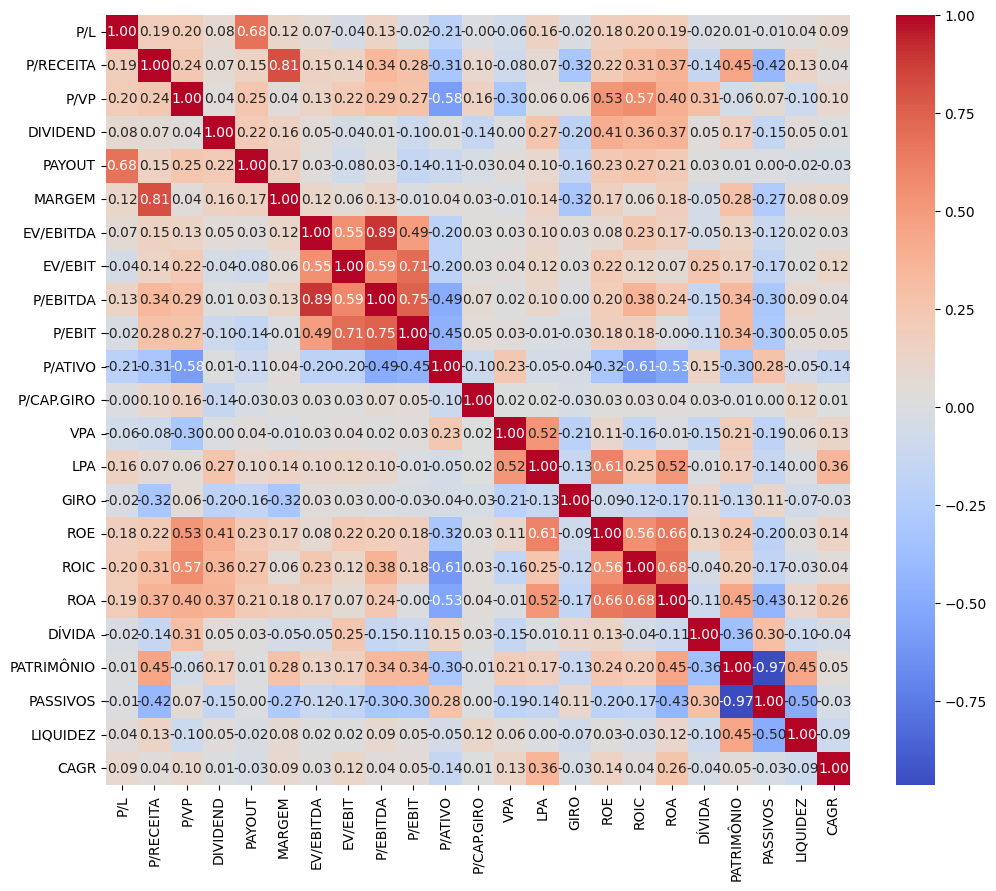

In [135]:
mat_corr_raw = df_ind_fund_raw.corr()

plt.figure(figsize=(12,10))
sns.heatmap(mat_corr_raw, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

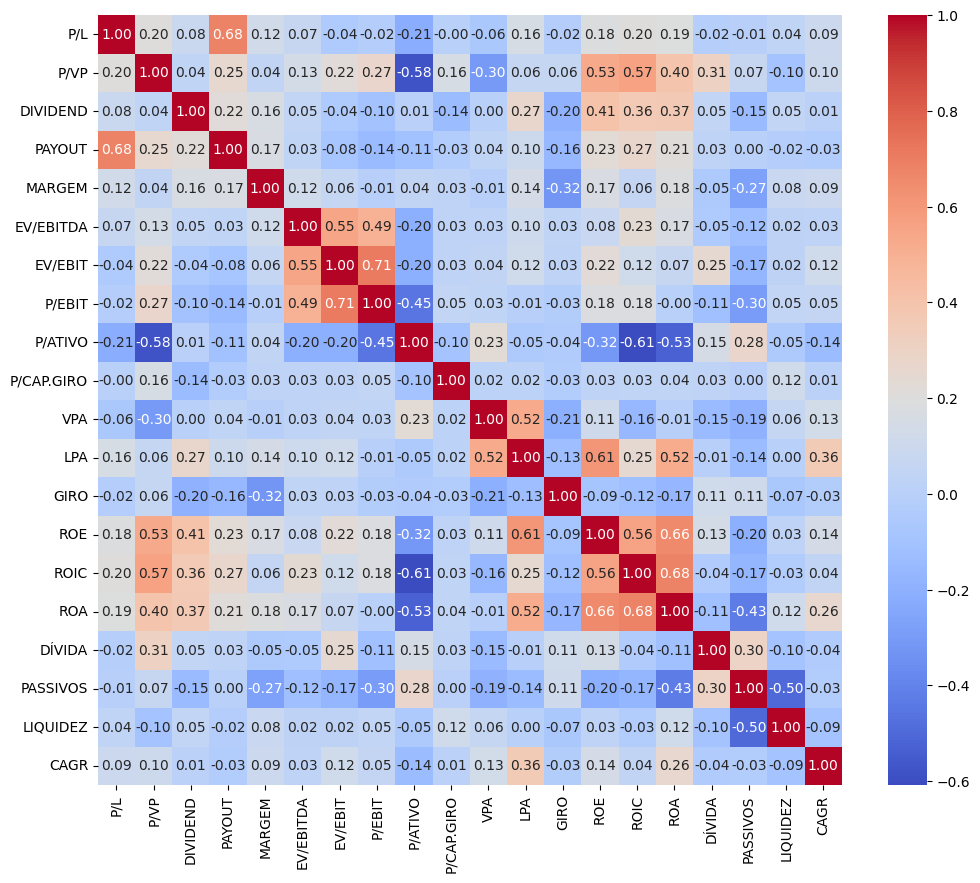

In [136]:
df_ind_fund = df_ind_fund_raw.drop(columns = fn_altamente_correlacionados(mat_corr_raw, 0.8))

mat_corr = df_ind_fund.corr()
plt.figure(figsize=(12,10))
sns.heatmap(mat_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [138]:
mat_corr_raw['MARGEM']

P/L           0.123347
P/RECEITA     0.809442
P/VP          0.044179
DIVIDEND      0.159722
PAYOUT        0.166939
MARGEM        1.000000
EV/EBITDA     0.119483
EV/EBIT       0.058358
P/EBITDA      0.131271
P/EBIT       -0.011068
P/ATIVO       0.043297
P/CAP.GIRO    0.028458
VPA          -0.011159
LPA           0.143678
GIRO         -0.320075
ROE           0.167035
ROIC          0.056764
ROA           0.183531
DÍVIDA       -0.051605
PATRIMÔNIO    0.282209
PASSIVOS     -0.273799
LIQUIDEZ      0.082164
CAGR          0.091970
Name: MARGEM, dtype: float64

# Preços

In [ ]:
dt_ini, dt_fim =  '2020-01-01','2024-08-01'
df_precos = pd.DataFrame()
df_precos = yf.download(tickers, dt_ini, dt_fim)['Close']

In [ ]:
#validacao
serie = df_precos.isnull().sum()
serie = serie[serie>0]
ativos_nulos = list(serie.index)
ativos_nulos

Foram buscados precos a partir de 2023 de modo que todos os ativos tivessem precos pois alguns ativos , como ALOS3 não tinham precos antes desta data

In [ ]:
dt_ini, dt_fim =  '2023-01-01','2024-08-01'
df_precos = pd.DataFrame()
df_precos = yf.download(tickers, dt_ini, dt_fim)['Close']